# Тестовое задание

### 0. Изучить данные

In [1]:
import pandas as pd

import numpy as np 

import statsmodels.api as sm

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from prophet import Prophet

/Users/galina/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/galina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/galina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
#загружаю таблицу 
df = pd.read_excel('Тест ордерс.xlsx')

In [3]:
#смотрю основную инфо по таблице 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   id_o     1000000 non-null  int64  
 1   user_id  1000000 non-null  int64  
 2   price    1000000 non-null  float64
 3   o_date   1000000 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 30.5+ MB


In [4]:
df.head()

,id_o,user_id,price,o_date
0,3529360,2838448,1223.6,01.01.2017 AD
1,3529361,2838449,1893.5,01.01.2017 AD
2,3529362,2184575,1407.0,01.01.2017 AD
3,3529366,1935335,664.3,01.01.2017 AD
4,3529372,1935335,418.6,01.01.2017 AD


In [5]:
df.tail()

,id_o,user_id,price,o_date
999995,6522240,5468664,1399.3,07.12.2017 AD
999996,6522243,5468601,1603.0,07.12.2017 AD
999997,6522248,5033387,8398.6,07.12.2017 AD
999998,6522249,5468667,730.8,07.12.2017 AD
999999,6522255,5468697,864.5,07.12.2017 AD


In [6]:
#удаляю из o_date символы _AD
df['o_date'] = df['o_date'].map(lambda x: str(x)[:-3]) 

In [7]:
#перевожу данные в столбце o_date в дату
df['o_date'] = pd.to_datetime(df['o_date'], format='%d.%m.%Y')

In [8]:
#индексирую по дате:
df = df.set_index('o_date')

In [9]:
#оставляю в столбце price данные больше 0, так как ни цен, ни выручки < 0 нет
df = df.loc[df['price'] >= 0]

### 1. Найти данные по выручке в разрезе год-месяц,  кол-ву заказов, количеству уникальных купивших пользователей.

In [26]:
df.groupby(df.index.strftime('%B'))['price'].sum().sort_values()

o_date
December      62575197.3
February     161617657.6
January      176756702.5
June         184955837.5
July         187225893.4
April        197661211.3
August       205855839.7
September    212034384.1
March        214789307.6
May          217075552.4
October      280213863.3
November     326694750.9
Name: price, dtype: float64

In [10]:
print('Выручка total:', round(df['price'].sum(), 2))
print()
print('Месячная выручка по возрастанию:')
df.groupby(df.index.strftime('%B'))['price'].sum().sort_values()

Выручка total: 2427456197.6

Месячная выручка по возрастанию:


o_date
December      62575197.3
February     161617657.6
January      176756702.5
June         184955837.5
July         187225893.4
April        197661211.3
August       205855839.7
September    212034384.1
March        214789307.6
May          217075552.4
October      280213863.3
November     326694750.9
Name: price, dtype: float64

Наиболее прибыльный месяц 2017 года - ноябрь, наименее - декабрь, это объясняется тем, что есть данные только за первые 7 дней декабря

In [11]:
print('Общее кол-во заказов:', len(df['user_id']))
print()
print('Месячное кол-во заказов по возрастанию:')
df.groupby(df.index.strftime('%B'))['id_o'].count().sort_values()

Общее кол-во заказов: 999998

Месячное кол-во заказов по возрастанию:


o_date
December      27224
February      70652
January       75968
July          77002
June          77343
September     80976
August        84375
April         85307
March         90348
May           91949
October      106972
November     131882
Name: id_o, dtype: int64

Ожидаемо между месячным кол-вом заказов и выручкой зависимость прямо пропорциональная

In [12]:
print('Всего покупателей-уников:', len(df['user_id'].unique()))
print()
print('Кол-во покупателей-уников в месяц по возрастанию:')
df.groupby(df.index.strftime('%B'))['user_id'].nunique().sort_values()

Всего покупателей-уников: 568003

Кол-во покупателей-уников в месяц по возрастанию:


o_date
December      24365
February      55014
January       58409
June          59830
July          60253
April         63825
September     64765
August        66784
March         68011
May           68670
October       84248
November     105336
Name: user_id, dtype: int64

Ожидаемо между месячным кол-вом уников и выручкой зависимость прямо пропорциональная

### 2. Найти коэффициенты сезонности по месяцам

In [13]:
#коэффициент сезонности месяца = продажи в штуках месяца/ продажи за год
season = df.groupby(df.index.strftime('%B'))['id_o'].count()/len(df['id_o'])
print('Коэффициенты сезонности по месяцам по возрастанию:')
print(season.sort_values())

Коэффициенты сезонности по месяцам по возрастанию:
o_date
December     0.027224
February     0.070652
January      0.075968
July         0.077002
June         0.077343
September    0.080976
August       0.084375
April        0.085307
March        0.090348
May          0.091949
October      0.106972
November     0.131882
Name: id_o, dtype: float64


Самый высокий коэффициент сезонности в ноябре, октябре и мае, что логично, так как родители закупают товары к лету, к зиме и к НГ

### 3. Найти тренд и его уравнение

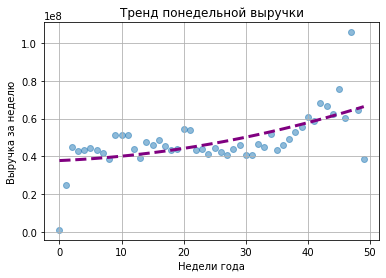

Уравнение тренда:
8962.089613768614 * x + 37789781.882714964


In [14]:
#поскольку декабрь представлен только первыми 7 днями, тренд сделала с разбивкой выручки понедельно
weekly_revenue = pd.DataFrame(df.groupby(df.index.strftime('%W'))['price'].sum())

x = weekly_revenue.index.values.astype('int')
y = weekly_revenue.price

plt.scatter(x, y, alpha=.5)

z = np.polyfit(x, y, 2)
p = np.poly1d(z)

plt.plot(x, p(x), color='purple', linewidth=3 , linestyle='--') 

plt.title('Тренд понедельной выручки')
plt.xlabel('Недели года')
plt.ylabel('Выручка за неделю')
plt.grid(True)
plt.show()

print('Уравнение тренда:')
print("{0} * x + {2}".format(*z))

### 4. Спрогнозировать продажи на след год (именно выручку) в разрезе год-месяц по любой методологии

In [15]:
monthly_revenue = pd.DataFrame(df.groupby(df.index.strftime('%Y-%b'))['price'].sum())
monthly_revenue['ds'] = monthly_revenue.index
monthly_revenue.rename(columns={'price':'y'}, inplace=True)
monthly_revenue['ds'] = pd.to_datetime(monthly_revenue['ds'])

16:36:14 - cmdstanpy - INFO - Chain [1] start processing
16:36:14 - cmdstanpy - INFO - Chain [1] done processing


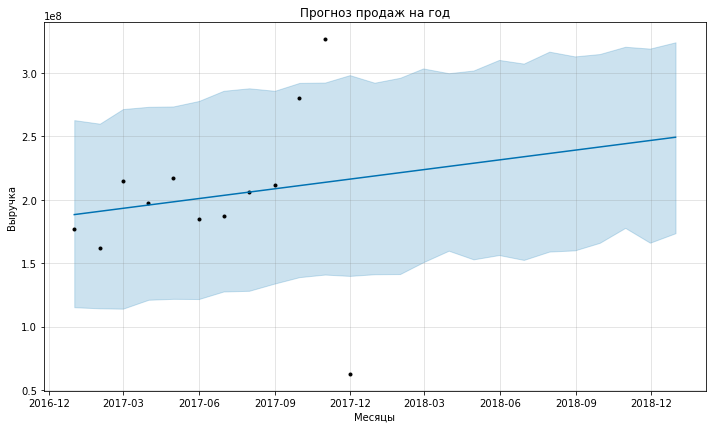

In [16]:
model = Prophet() #yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode='multiplicative'
model.fit(monthly_revenue)
future = model.make_future_dataframe(periods=13, freq='m')
forecast = model.predict(future)

model.plot(forecast)
plt.title('Прогноз продаж на год')
plt.xlabel('Месяцы')
plt.ylabel('Выручка')
plt.grid(True)
plt.show()

In [20]:
forecast_1year = pd.DataFrame(forecast[13:][['ds', 'yhat']])
forecast_1year.rename(columns={'ds':'month-2018', 'yhat':'revenue_forecast'}, inplace=True)
pd.options.display.float_format ='{:.2f}'.format
print('Прогноз выручки на 2018 год')
forecast_1year                                                                

Прогноз выручки на 2018 год


,month-2018,revenue_forecast
13,2018-01-31,221387919.92
14,2018-02-28,223731146.82
15,2018-03-31,226325433.75
16,2018-04-30,228836034.00
17,2018-05-31,231430320.93
18,2018-06-30,233940921.19
19,2018-07-31,236535208.12
20,2018-08-31,239129495.05
21,2018-09-30,241640095.30
22,2018-10-31,244234382.23


### 5. Ответить на вопрос, от чего зависит товарооборот конкретного дня

От количества заказов и суммы заказов (либо всего магазина, тогда это суммарный товарооборот, либо конкретного товара). То есть суммарный товарооборот первого дня будет такой:

In [18]:
print('Товарооборот первого дня =', df.groupby(df.index.strftime('%d'))['price'].sum()[0])

Товарооборот первого дня = 74412817.5


Очень успешный магазин, если 1 января он продал аж на 74.4 млн руб

### 6. Сделать предположение по возможной очистке данных и /или их особенностям

Что касается очистки, то выше я удалила отрицательные значения в столбце price и AD из даты (кстати, что  значит AD? Anno Domini?)

Также я бы посмотрела недельную сезонность, так как в рознице иногда бывают "кошачьи уши" в определенные дни недели. Предполагаю, что родители больше покупают детских товаров в пятницу-субботу